#  m12m positioned at CenA
Find attached "image" file for m12m positioned at CenA! In this projection, the relative radial velocity for the bound remnant is +19 km/s. 

Dwarf progenitor at z=0 is 1.2e8 M_sun

In [70]:
#imports to be used later on
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cms
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
from matplotlib.cm import get_cmap
from astropy.io import fits
import matplotlib
import scipy.ndimage
import scipy.interpolate
from astropy.table import Table
import astropy.units as u
%matplotlib inline

import math
import matplotlib.patches as patches

import random

# gala
import gala.coordinates as gc
#import gala.dynamics as gd
#import gala.potential as gp
from gala.units import galactic
import gala.integrate as gi
from gala.units import galactic, UnitSystem

import astropy.coordinates as coord
from astropy.coordinates import SkyOffsetFrame 
from astropy.wcs import WCS
plt.ioff

from scipy.optimize import minimize

#import reproject

from scipy.interpolate import interp1d

# Default gala cosmology: # WMAP7 cosmology in effect
# from astropy import cosmology
# cosmo = cosmology.default_cosmology.get()

from functools import partial

from gala.units import UnitSystem
import time

import jax
import jax.numpy as jnp

#from jax.config import config
jax.config.update("jax_enable_x64", True)



import jax.random as random 
from matplotlib.patches import Ellipse
import jax.scipy.stats as statsjax

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt,PIDController,DiscreteTerminatingEvent, DirectAdjoint, RecursiveCheckpointAdjoint
import JaxStreams_Information as JaxStreams 

from jax.scipy.stats import gaussian_kde
import tqdm

import seaborn as sns

In [71]:
data_path = "data/"

In [72]:
mpl.rcParams.update({'font.size': 20})
label_size = 20
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18#label_size 

In [73]:
#keeping these below for plots with both streams
pos = np.load(data_path + 'm12m_streams_pos.npy')
vel = np.load(data_path + 'm12m_streams_vel.npy')


#these velow are rhe streams separated 
#outer: short straight stream
pos_outer= np.load(data_path + 'm12m_intact_prog_pos.npy')
vel_outer = np.load(data_path + 'm12m_intact_prog_vel.npy')


pos_inner = np.load(data_path + 'm12m_massive_stream_pos.npy')
vel_inner = np.load(data_path + 'm12m_massive_stream_vel.npy')




In [74]:
plot_path = "Figs/"

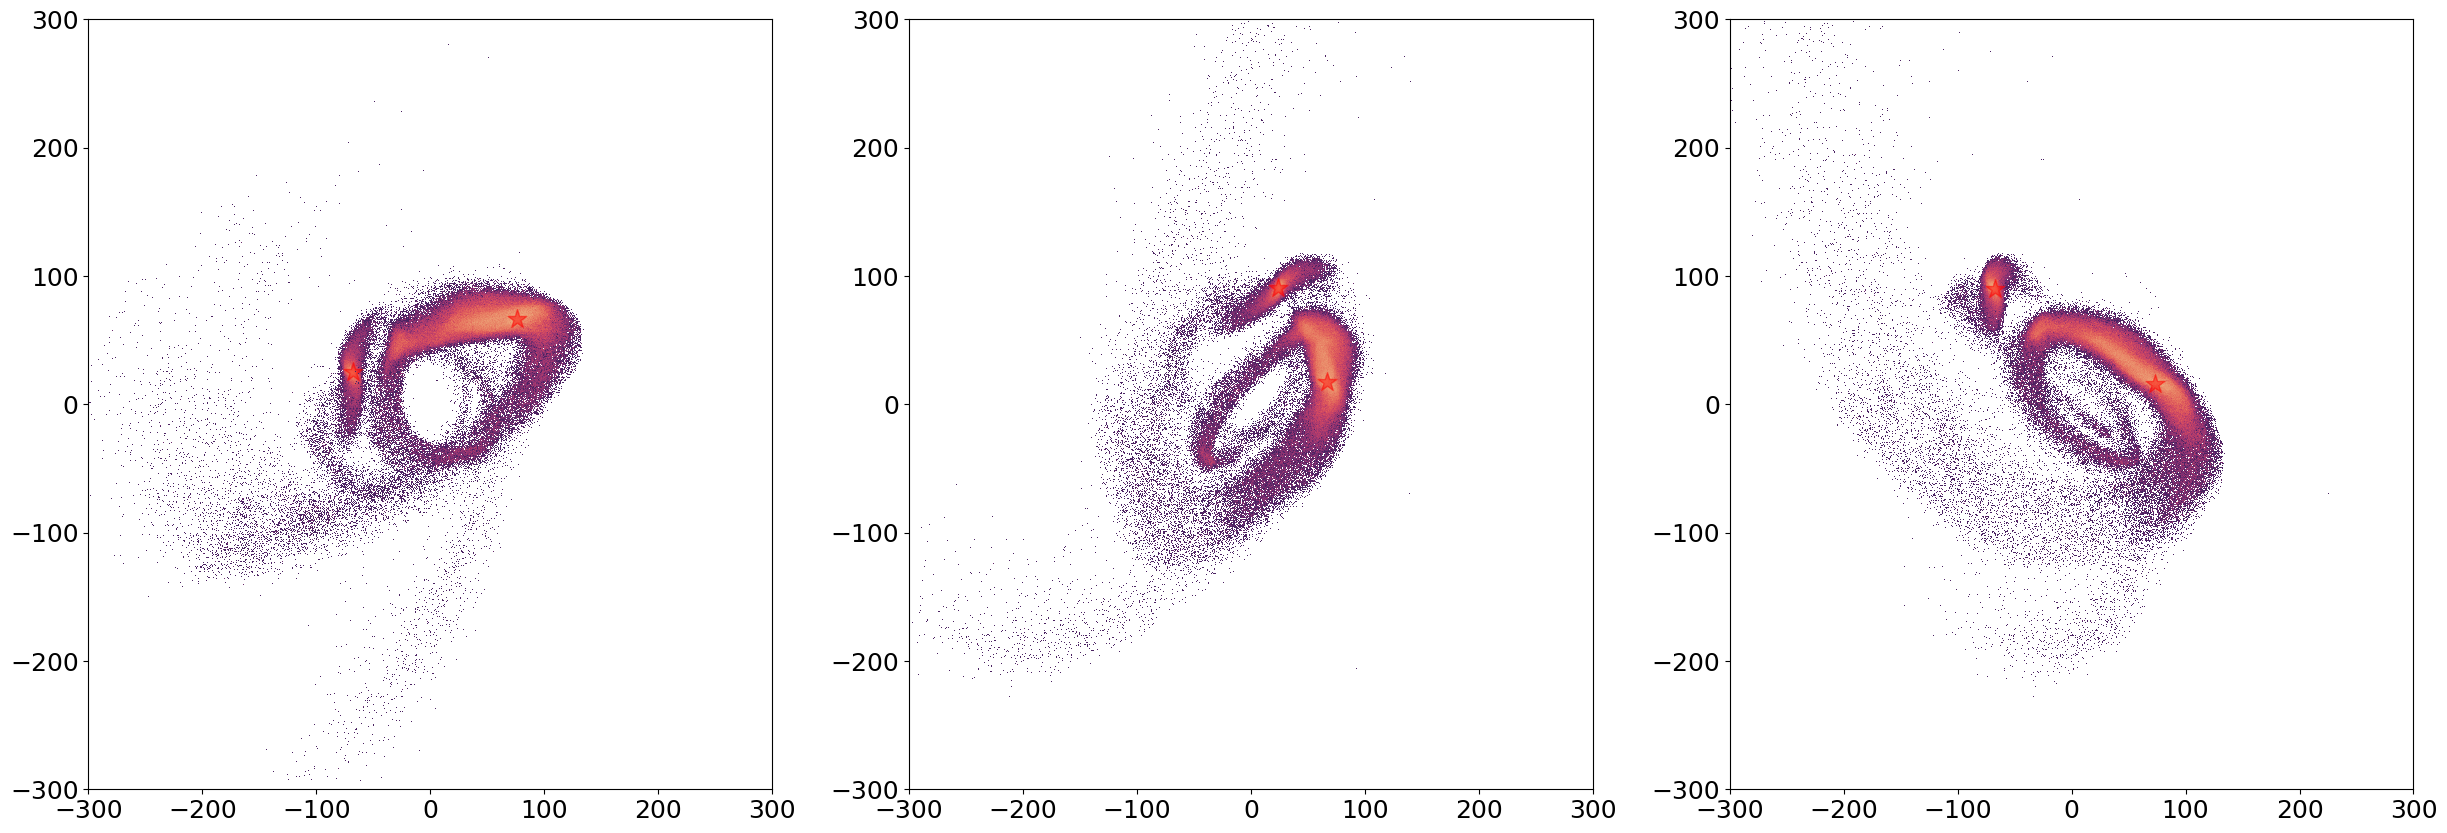

In [75]:
histcolor = sns.color_palette("flare_r", as_cmap=True)
#sns.color_palette("mako", as_cmap=True)#sns.cubehelix_palette(as_cmap=True)#sns.color_palette("rocket", as_cmap=True)

f, ax=plt.subplots(1,3, figsize=(30,10))

counts_1outer, xedges_1outer, yedges_1outer, im_1outer = ax[0].hist2d(pos_outer[:,0], pos_outer[:,1], cmap = histcolor, bins=np.linspace(-300,300,800), norm=LogNorm());
counts_2outer, xedges_2outer, yedges_2outer, im_2outer=  ax[1].hist2d(pos_outer[:,1], pos_outer[:,2], cmap = histcolor,bins=np.linspace(-300,300,800), norm=LogNorm());
counts_3outer, xedges_3outer, yedges_3outer, im_3outer = ax[2].hist2d(pos_outer[:,0], pos_outer[:,2], cmap = histcolor,bins=np.linspace(-300,300,800), norm=LogNorm());

#Now grab progenitors 
prog_outer1_index =  np.unravel_index(np.argmax(counts_1outer), counts_1outer.shape)
x_center_outer1 = 0.5 * (xedges_1outer[prog_outer1_index[0]] + xedges_1outer[prog_outer1_index[0] + 1])
y_center_outer1 = 0.5 * (yedges_1outer[prog_outer1_index[1]] + yedges_1outer[prog_outer1_index[1] + 1])

prog_outer2_index =  np.unravel_index(np.argmax(counts_2outer), counts_2outer.shape)
x_center_outer2 = 0.5 * (xedges_2outer[prog_outer2_index[0]] + xedges_2outer[prog_outer2_index[0] + 1])
y_center_outer2 = 0.5 * (yedges_2outer[prog_outer2_index[1]] + yedges_2outer[prog_outer2_index[1] + 1])

prog_outer3_index =  np.unravel_index(np.argmax(counts_3outer), counts_3outer.shape)
x_center_outer3 = 0.5 * (xedges_3outer[prog_outer3_index[0]] + xedges_3outer[prog_outer3_index[0] + 1])
y_center_outer3 = 0.5 * (yedges_3outer[prog_outer3_index[1]] + yedges_3outer[prog_outer3_index[1] + 1])

# Now plot progenitors
#print(prog_outer1_index,x_center_outer1,y_center_outer1 )
ax[0].scatter(x_center_outer1,y_center_outer1, marker='*', s=200, color='r', alpha=0.5)
ax[1].scatter(x_center_outer2,y_center_outer2, marker='*', s=200, color='r', alpha=0.5)
ax[2].scatter(x_center_outer3,y_center_outer3, marker='*', s=200, color='r', alpha=0.5)


counts_1inner, xedges_1inner, yedges_1inner, im_1inner = ax[0].hist2d(pos_inner[:,0], pos_inner[:,1],cmap = histcolor,bins=np.linspace(-300,300,800), norm=LogNorm());
counts_2inner, xedges_2inner, yedges_2inner, im_2inner = ax[1].hist2d(pos_inner[:,1], pos_inner[:,2],cmap = histcolor, bins=np.linspace(-300,300,800), norm=LogNorm());
counts_3inner, xedges_3inner, yedges_3inner, im_3inner = ax[2].hist2d(pos_inner[:,0], pos_inner[:,2],cmap = histcolor, bins=np.linspace(-300,300,800), norm=LogNorm());

#Now grab progenitors 
prog_inner1_index =  np.unravel_index(np.argmax(counts_1inner), counts_1inner.shape)
x_center_inner1 = 0.5 * (xedges_1inner[prog_inner1_index[0]] + xedges_1inner[prog_inner1_index[0] + 1])
y_center_inner1 = 0.5 * (yedges_1inner[prog_inner1_index[1]] + yedges_1inner[prog_inner1_index[1] + 1])


prog_inner2_index =  np.unravel_index(np.argmax(counts_2inner), counts_2inner.shape)
x_center_inner2 = 0.5 * (xedges_2inner[prog_inner2_index[0]] + xedges_2inner[prog_inner2_index[0] + 1])
y_center_inner2 = 0.5 * (yedges_2inner[prog_inner2_index[1]] + yedges_2inner[prog_inner2_index[1] + 1])

prog_inner3_index =  np.unravel_index(np.argmax(counts_3inner), counts_3inner.shape)
x_center_inner3 = 0.5 * (xedges_3inner[prog_inner3_index[0]] + xedges_3inner[prog_inner3_index[0] + 1])
y_center_inner3 = 0.5 * (yedges_3inner[prog_inner3_index[1]] + yedges_3inner[prog_inner3_index[1] + 1])


# Now plot progenitors
#print(prog_outer1_index,x_center_outer1,y_center_outer1 )
ax[0].scatter(x_center_inner1,y_center_inner1, marker='*', s=200, color='r', alpha=0.5)
ax[1].scatter(x_center_inner2,y_center_inner2, marker='*', s=200, color='r', alpha=0.5)
ax[2].scatter(x_center_inner3,y_center_inner3, marker='*', s=200, color='r', alpha=0.5)




In [76]:
## Now find vrad for the velocities for each of the 6 progenitors, 2 per projection 

bins=np.linspace(-300,300,800)
# Create a 2D histogram to bin the data

####################
H, xedges, yedges = np.histogram2d(pos_outer[:, 0], pos_outer[:, 1], bins=[bins, bins])
binned_velocities_o1 = np.zeros(H.shape)

for i in range(len(pos_outer)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_outer[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_outer[i, 1], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_o1.shape[0] and 0 <= y_bin < binned_velocities_o1.shape[1]:
        binned_velocities_o1[x_bin, y_bin] += vel_outer[i, 2]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_o1.shape[0]):
    for j in range(binned_velocities_o1.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_o1[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_outer[:, 1], pos_outer[:, 2], bins=[bins, bins])
binned_velocities_o2 = np.zeros(H.shape)

for i in range(len(pos_outer)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_outer[i, 1], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_outer[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_o2.shape[0] and 0 <= y_bin < binned_velocities_o2.shape[1]:
        binned_velocities_o2[x_bin, y_bin] += vel_outer[i, 0]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_o1.shape[0]):
    for j in range(binned_velocities_o2.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_o2[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_outer[:, 0], pos_outer[:, 2], bins=[bins, bins])
binned_velocities_o3 = np.zeros(H.shape)

for i in range(len(pos_outer)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_outer[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_outer[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_o3.shape[0] and 0 <= y_bin < binned_velocities_o3.shape[1]:
        binned_velocities_o3[x_bin, y_bin] += vel_outer[i, 1]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_o3.shape[0]):
    for j in range(binned_velocities_o3.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_o3[i, j] /= count



############################

####################
H, xedges, yedges = np.histogram2d(pos_inner[:, 0], pos_inner[:, 1], bins=[bins, bins])
binned_velocities_i1 = np.zeros(H.shape)

for i in range(len(pos_inner)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_inner[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_inner[i, 1], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_i1.shape[0] and 0 <= y_bin < binned_velocities_i1.shape[1]:
        binned_velocities_i1[x_bin, y_bin] += vel_inner[i, 2]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_i1.shape[0]):
    for j in range(binned_velocities_i1.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_i1[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_inner[:, 1], pos_inner[:, 2], bins=[bins, bins])
binned_velocities_i2 = np.zeros(H.shape)

for i in range(len(pos_inner)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_inner[i, 1], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_inner[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_i2.shape[0] and 0 <= y_bin < binned_velocities_i2.shape[1]:
        binned_velocities_i2[x_bin, y_bin] += vel_inner[i, 0]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_i1.shape[0]):
    for j in range(binned_velocities_i2.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_i2[i, j] /= count


###################
H, xedges, yedges = np.histogram2d(pos_inner[:, 0], pos_inner[:, 2], bins=[bins, bins])
binned_velocities_i3 = np.zeros(H.shape)

for i in range(len(pos_inner)):
    # Find the bin index for each position
    x_bin = np.digitize(pos_inner[i, 0], bins) - 1  # -1 for 0-based index
    y_bin = np.digitize(pos_inner[i, 2], bins) - 1  # -1 for 0-based index
    
    if 0 <= x_bin < binned_velocities_i3.shape[0] and 0 <= y_bin < binned_velocities_i3.shape[1]:
        binned_velocities_i3[x_bin, y_bin] += vel_inner[i, 1]

# Normalize the binned velocities by the counts (optional)
for i in range(binned_velocities_i3.shape[0]):
    for j in range(binned_velocities_i3.shape[1]):
        count = H[i, j]
        if count > 0:
            binned_velocities_i3[i, j] /= count


# The resulting shape should be (799, 799)
#print(binned_velocities_o1.shape)  # Should print (799, 799)

#binned_velocities[prog_outer1_index]

Text(0, 0.5, 'Perpendicular Velocity [km/s]')

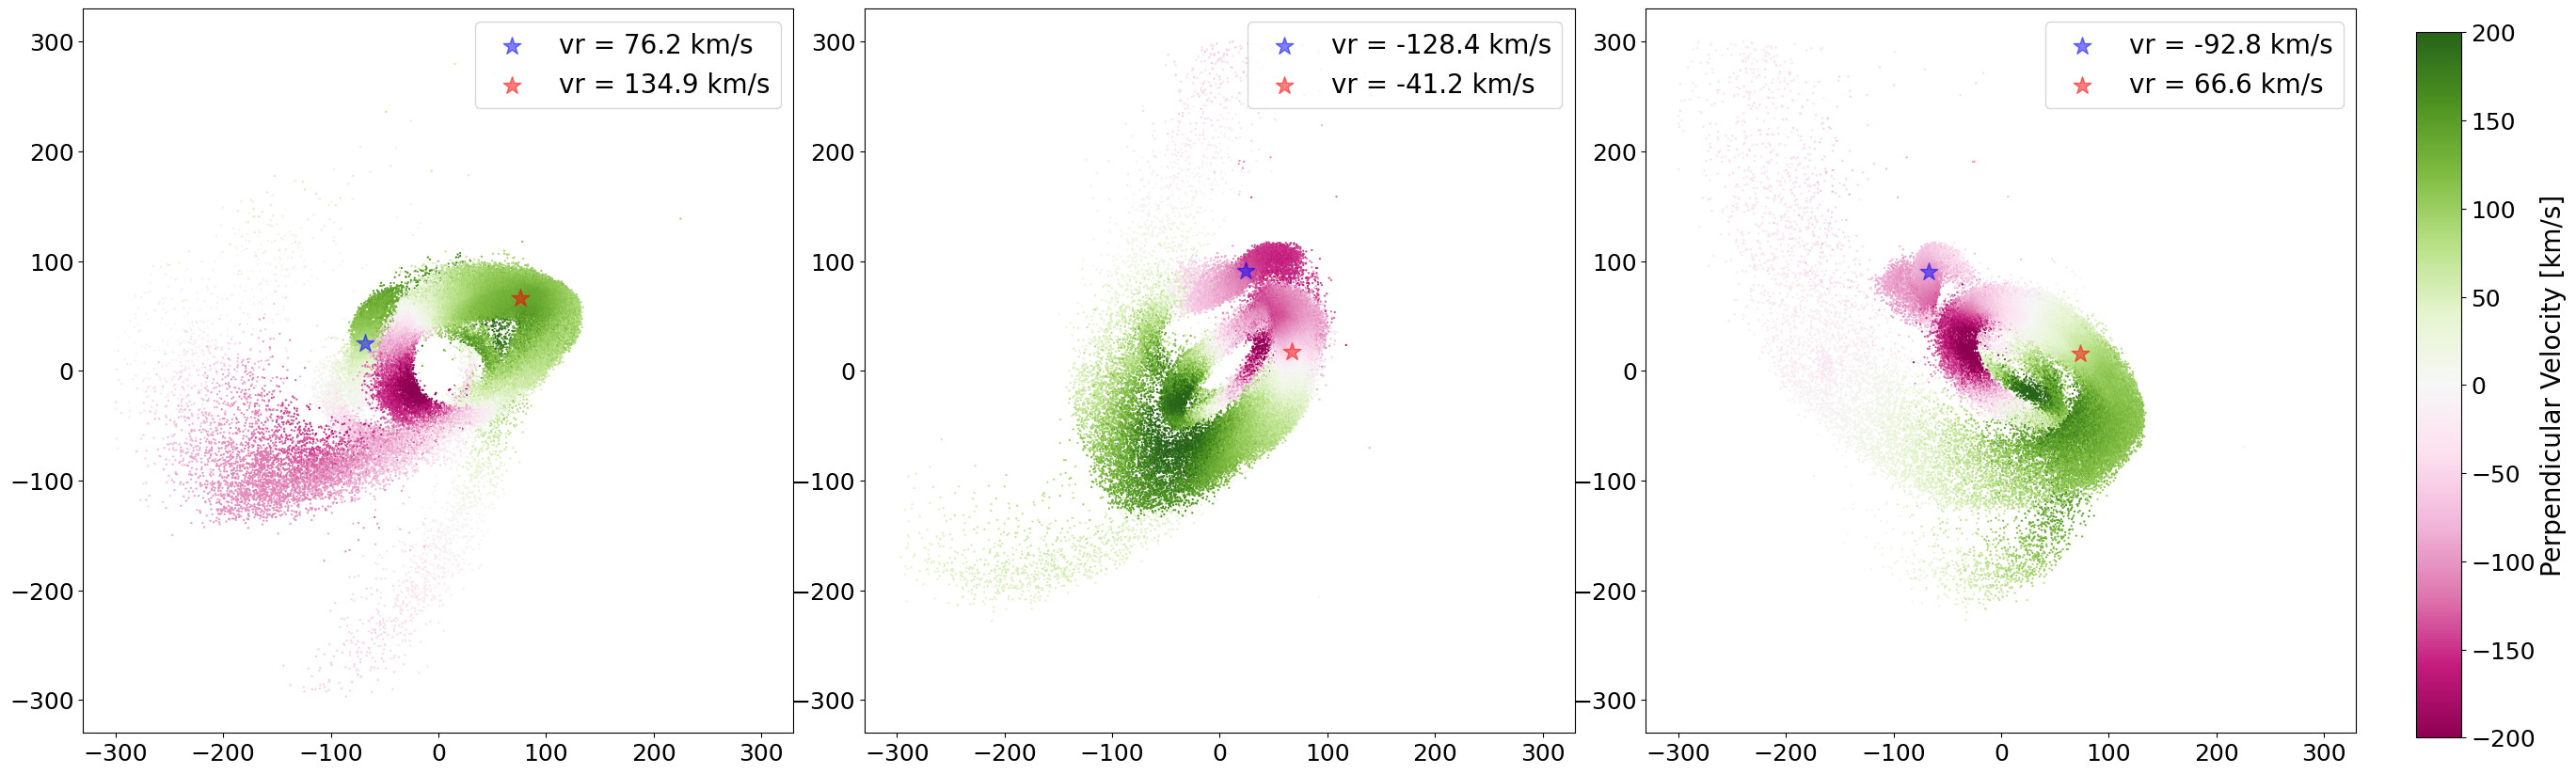

In [77]:

f, ax=plt.subplots(1,3, figsize=(32,10))
hb = ax[0].hexbin(pos_outer[:,0], pos_outer[:,1], gridsize=800, extent=[-300,300,-300,300], C=vel_outer[:,2], cmap='PiYG', vmin=-200, vmax=200);
ax[1].hexbin(pos_outer[:,1], pos_outer[:,2], gridsize=800, extent=[-300,300,-300,300], C=vel_outer[:,0], cmap='PiYG', vmin=-200, vmax=200);
cmap=ax[2].hexbin(pos_outer[:,0], pos_outer[:,2], gridsize=800, extent=[-300,300,-300,300], C=vel_outer[:,1], cmap='PiYG', vmin=-200, vmax=200);

ax[0].hexbin(pos_inner[:,0], pos_inner[:,1], gridsize=800, extent=[-300,300,-300,300], C=vel_inner[:,2], cmap='PiYG', vmin=-200, vmax=200);
ax[1].hexbin(pos_inner[:,1], pos_inner[:,2], gridsize=800, extent=[-300,300,-300,300], C=vel_inner[:,0], cmap='PiYG', vmin=-200, vmax=200);
ax[2].hexbin(pos_inner[:,0], pos_inner[:,2], gridsize=800, extent=[-300,300,-300,300], C=vel_inner[:,1], cmap='PiYG', vmin=-200, vmax=200);

#radial velocities 
ax[0].scatter(x_center_outer1,y_center_outer1, marker='*', s=200, color='b', alpha=0.5,label ='vr = ' + str(np.round(binned_velocities_o1[prog_outer1_index],1)) + ' km/s')
ax[1].scatter(x_center_outer2,y_center_outer2, marker='*', s=200, color='b', alpha=0.5,label ='vr = ' + str(np.round(binned_velocities_o2[prog_outer2_index],1)) + ' km/s')
ax[2].scatter(x_center_outer3,y_center_outer3, marker='*', s=200, color='b', alpha=0.5,label ='vr = ' + str(np.round(binned_velocities_o3[prog_outer3_index],1)) + ' km/s')

ax[0].scatter(x_center_inner1,y_center_inner1, marker='*', s=200, color='r', alpha=0.5,label ='vr = ' + str(np.round(binned_velocities_i1[prog_inner1_index],1)) + ' km/s')
ax[1].scatter(x_center_inner2,y_center_inner2, marker='*', s=200, color='r', alpha=0.5,label ='vr = ' + str(np.round(binned_velocities_i2[prog_inner2_index],1)) + ' km/s')
ax[2].scatter(x_center_inner3,y_center_inner3, marker='*', s=200, color='r', alpha=0.5,label ='vr = ' + str(np.round(binned_velocities_i3[prog_inner3_index],1)) + ' km/s')

#plt.scatter(binned_velocities[prog_outer1_index]
ax[0].legend()
ax[1].legend()
ax[2].legend()
#plt.colorbar(mappable=cmap)

f.subplots_adjust(right=0.88, wspace=0.1)
cbar_ax = f.add_axes([0.9, 0.105, 0.015, 0.75])
cb=f.colorbar(mappable=cmap, cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel('Perpendicular Velocity [km/s]')


# Now make histograms with red points for new methods 

In [78]:
#from data make histogram of stream
#thresh: how many particles need to be in the bin 

def gen_stream_hist(stream_dim1,stream_dim2,thresh,xlin,zlin):
    """On sky x an z, xlin, zlin defines bin in each dimension"""
    H  = jnp.histogram2d(stream_dim1,stream_dim2,bins=(xlin,zlin))
    hist2d = H[0]
    #only keep things above the threshold
    masked_hist = jnp.where(hist2d>thresh,1.0,0.0)
    xinds, zinds = jnp.where(masked_hist == 1.)
    
    #even if only one star in a bin, wherever hist2 is grater than threshold, then use that
    # value otherwise zero and then normalize it 
    weights_of_pts = jnp.where(hist2d>thresh,hist2d,0.0)
    weights_of_pts = weights_of_pts/weights_of_pts.sum()
    
    #dx_over_2 = (xlin[2] - xlin[1])/2
    #dz_over_2 =  (zlin[2] - zlin[1])/2
    # Compute bin centers along both axes
    x_centers = 0.5 * (xlin[:-1] + xlin[1:])
    z_centers = 0.5 * (zlin[:-1] + zlin[1:])
    
    #spits out histogram (nxn grid dim of zlin zlin, value of histogram, midpoints)
    #indexed so also get coordinates of histogram points
    return masked_hist.T, weights_of_pts[xinds,zinds], x_centers[xinds], z_centers[zinds]#xlin[xinds] + dx_over_2, zlin[zinds] + dz_over_2

xlin_inner = jnp.linspace(-200,200,50)
zlin_inner = jnp.linspace(-200,200,50)
#for image you would just choose control poibts 
#for imaging wouldn't have the histogram step, just step of points (red)
#for image data just select out pixels where you are above a threshold, don't need histogram step
#the red are the datapoints we evaluate over

#for plot
H_proj1, weights, xpts, zpts = gen_stream_hist(pos[:,0],pos[:,1],100,xlin_inner,zlin_inner)
H_proj2, weights, xpts2, zpts2 = gen_stream_hist(pos[:,1],pos[:,2],100,xlin_inner,zlin_inner)
H_proj3, weights, xpts3, zpts3 = gen_stream_hist(pos[:,0],pos[:,2],100,xlin_inner,zlin_inner)



# for method 
#thresh = 200
H_proj1_inner, weights_inner, xpts_inner, zpts_inner = gen_stream_hist(pos_inner[:,0],pos_inner[:,1],100,xlin_inner,zlin_inner)
H_proj1_outer, weights_outer, xpts_outer, zpts_outer = gen_stream_hist(pos_outer[:,0],pos_outer[:,1],100,xlin_inner,zlin_inner)

H_proj2_inner, weights_inner2, xpts_inner2, zpts_inner2 = gen_stream_hist(pos_inner[:,1], pos_inner[:,2],100,xlin_inner,zlin_inner)
H_proj2_outer, weights_outer2, xpts_outer2, zpts_outer2 = gen_stream_hist(pos[:,1], pos[:,2],100,xlin_inner,zlin_inner)

H_proj3_inner, weights_inner3, xpts_inner3, zpts_inner3 = gen_stream_hist(pos_inner[:,0], pos_inner[:,2],100,xlin_inner,zlin_inner)
H_proj3_outer, weights_outer3, xpts_outer3, zpts_outer3 = gen_stream_hist(pos_outer[:,0], pos_outer[:,2],100,xlin_inner,zlin_inner)




# H_proj1, weights_inner, xpts_inner, zpts_inner  = jnp.histogram2d(pos[:,0],pos[:,1],bins=(xlin,zlin))
# hist2d_proj1= H_proj1[0]
#     #only keep things above the threshold
# masked_hist = jnp.where(hist2d_proj1>thresh,1.0,0.0)
# xinds, zinds = jnp.where(masked_hist == 1.)

In [79]:
color_prog= sns.color_palette("Paired")

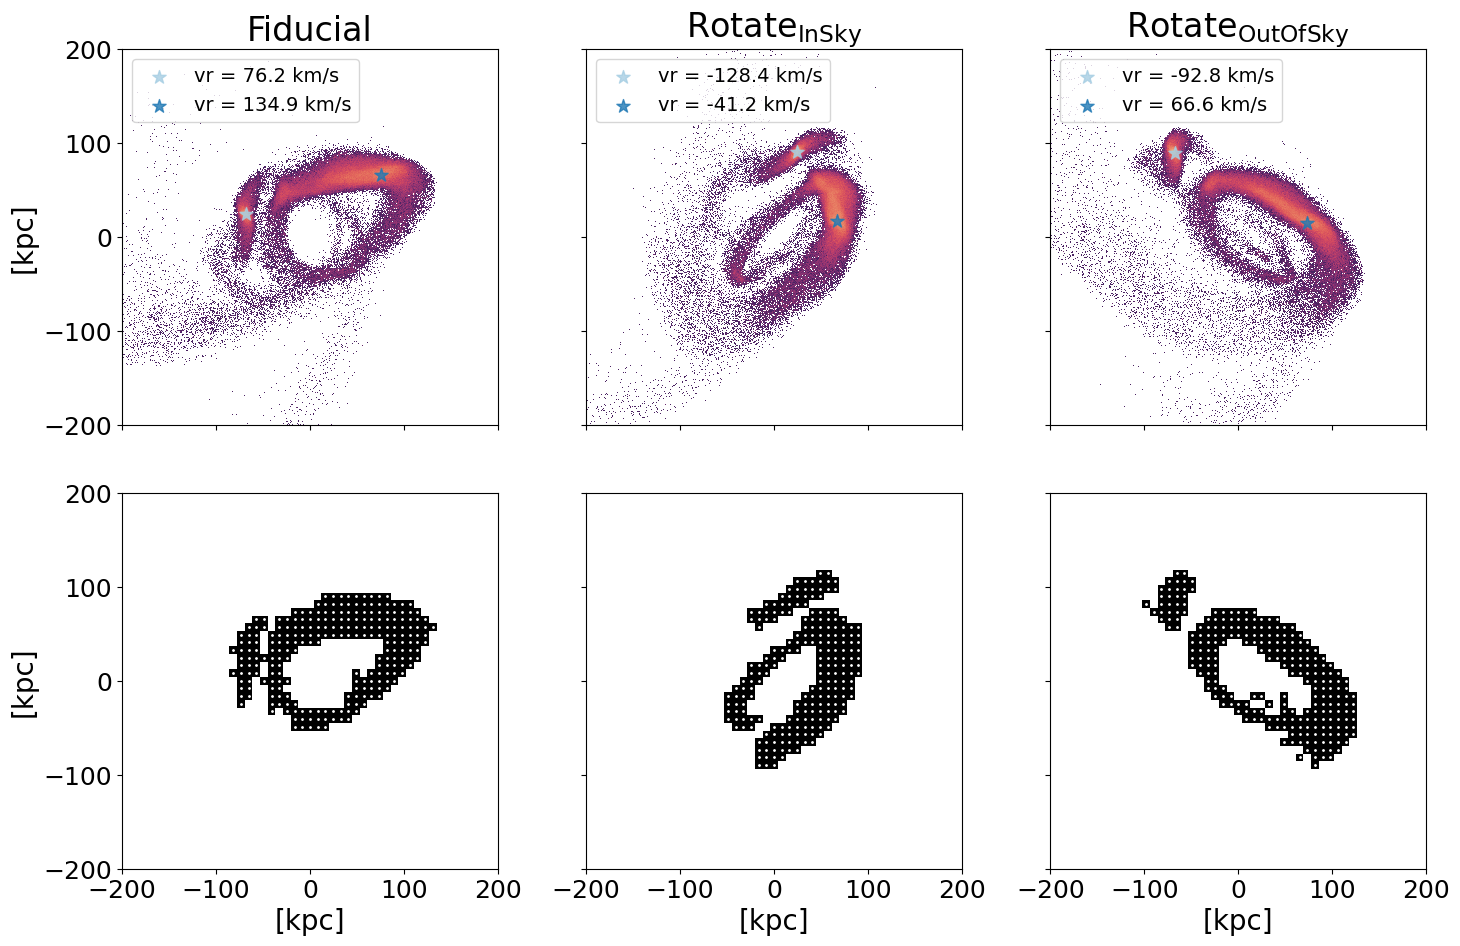

In [80]:
dat = jnp.vstack([xpts, zpts]).T
dat2 = jnp.vstack([xpts2, zpts2]).T
dat3 = jnp.vstack([xpts3, zpts3]).T


#I need these inner outer distinctions for running the method on one stream at a time
# for plotting i can use the combined dat files instead above. 
dat_inner = jnp.vstack([xpts_inner, zpts_inner]).T
dat_inner2 = jnp.vstack([xpts_inner2, zpts_inner2]).T
dat_inner3 = jnp.vstack([xpts_inner3, zpts_inner3]).T

dat_outer = jnp.vstack([xpts_outer, zpts_outer]).T
dat_outer2 = jnp.vstack([xpts_outer2, zpts_outer2]).T
dat_outer3 = jnp.vstack([xpts_outer3, zpts_outer3]).T
#dat_outer = jnp.vstack([xpts_outer, zpts_outer]).T


f, ax=plt.subplots(2,3, figsize=(15,10), sharex = True, sharey=True)
ax[0,0].set_title('Fiducial')#Projection 1')
ax[0,1].set_title(r'Rotate$_{\rm InSky}$')
ax[0,2].set_title(r'Rotate$_{\rm OutOfSky}$')

ax[0,0].hist2d(pos[:,0], pos[:,1], bins=np.linspace(-300,300,800),  cmap = histcolor,norm=LogNorm());
ax[0,1].hist2d(pos[:,1], pos[:,2], bins=np.linspace(-300,300,800), cmap = histcolor, norm=LogNorm());
ax[0,2].hist2d(pos[:,0], pos[:,2], bins=np.linspace(-300,300,800), cmap = histcolor, norm=LogNorm());


# Now plot progenitors
# #print(prog_outer1_index,x_center_outer1,y_center_outer1 )
# ax[0,0].scatter(x_center_inner1,y_center_inner1, marker='*', s=200, color='r', alpha=0.5)
# ax[0,1].scatter(x_center_inner2,y_center_inner2, marker='*', s=200, color='r', alpha=0.5)
# ax[0,2].scatter(x_center_inner3,y_center_inner3, marker='*', s=200, color='r', alpha=0.5)
# ax[0,0].scatter(x_center_outer1,y_center_outer1, marker='*', s=200, color='r', alpha=0.5)
# ax[0,1].scatter(x_center_outer2,y_center_outer2, marker='*', s=200, color='r', alpha=0.5)
# ax[0,2].scatter(x_center_outer3,y_center_outer3, marker='*', s=200, color='r', alpha=0.5)
#radial velocities 
ax[0,0].scatter(x_center_outer1,y_center_outer1, marker='*', s=100, color=color_prog[0], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_o1[prog_outer1_index],1)) + ' km/s')
ax[0,1].scatter(x_center_outer2,y_center_outer2, marker='*', s=100, color=color_prog[0], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_o2[prog_outer2_index],1)) + ' km/s')
ax[0,2].scatter(x_center_outer3,y_center_outer3, marker='*', s=100, color=color_prog[0], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_o3[prog_outer3_index],1)) + ' km/s')

ax[0,0].scatter(x_center_inner1,y_center_inner1, marker='*', s=100, color=color_prog[1], alpha=0.8,  label ='vr = ' + str(np.round(binned_velocities_i1[prog_inner1_index],1)) + ' km/s')
ax[0,1].scatter(x_center_inner2,y_center_inner2, marker='*', s=100, color=color_prog[1], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_i2[prog_inner2_index],1)) + ' km/s')
ax[0,2].scatter(x_center_inner3,y_center_inner3, marker='*', s=100, color=color_prog[1], alpha=0.8, label ='vr = ' + str(np.round(binned_velocities_i3[prog_inner3_index],1)) + ' km/s')



ax[0,0].set_xlim([-200,200])
ax[0,0].set_ylim([-200,200])
ax[0,0].set_ylabel('[kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].legend(loc='upper left', fontsize=14)

ax[0,1].set_aspect('equal')
ax[0,1].set_xlim([-200,200])
ax[0,1].set_ylim([-200,200])
ax[0,1].legend(loc='upper left', fontsize=14)

ax[0,2].set_xlim([-200,200])
ax[0,2].set_ylim([-200,200])
ax[0,2].set_aspect('equal')
ax[0,2].legend(loc='upper left', fontsize=14)


#f, ax=plt.subplots(1,3, figsize=(30,10))
#fig, ax = plt.subplots(1,1)
#fig.set_size_inches(5,5)
#fig.set_size_inches(10,10)
ax[1,0].pcolormesh(xlin_inner,zlin_inner,H_proj1,cmap='binary')
ax[1,0].scatter(dat[:,0],dat[:,1],color='w',s=1)
#ax[1,0].scatter(dat_inner[:,0],dat_inner[:,1],color='w',s=1)

# ax[1,0].pcolormesh(xlin_inner,zlin_inner,H_proj1_outer,cmap='binary')
# ax[1,0].scatter(dat_outer[:,0],dat_outer[:,1],color='r',s=.5)

#ax[0].scatter(dat_inner[:,0],dat_inner[:,1],color='r',s=.5
ax[1,0].set_aspect('equal')
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('[kpc]')
ax[1,0].set_ylabel('[kpc]')

ax[1,1].pcolormesh(xlin_inner,zlin_inner,H_proj2,cmap='binary')
ax[1,1].scatter(dat2[:,0],dat2[:,1],color='w',s=1)
#ax[0].scatter(dat_inner[:,0],dat_inner[:,1],color='r',s=.5
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel('[kpc]')
#red poitns here, is what the method actually needs 

ax[1,2].pcolormesh(xlin_inner,zlin_inner,H_proj3,cmap='binary')
ax[1,2].scatter(dat3[:,0],dat3[:,1],color='w',s=1)
#ax[0].scatter(dat_inner[:,0],dat_inner[:,1],color='r',s=.5
ax[1,2].set_aspect('equal')
ax[1,2].set_xlabel('[kpc]')

f.tight_layout()
#f.legend(handles, labels, loc='upper center', ncol=3)

f.savefig(plot_path+'projections.png')

## Now running Jake's method

In [81]:
# Now get ready to run Jake's method. 
jax.default_device('CudaDevice(id=3)')

In [82]:
# Check that Jax works  on GPU - should print GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


/tmp/ipykernel_668307/589522557.py:3: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


In [83]:
# for NWF potential
#helper function for nfw
@jax.jit
def get_nfw_rho0(M,r_s):
    c_NFW = 15. # following https://arxiv.org/pdf/2211.04495
    denom = jnp.log(1. + c_NFW) - (c_NFW/(1+c_NFW))
    fac = 1./denom
    rho0 = (M/(4*jnp.pi*r_s**3))*fac
    return rho0
np.log10(get_nfw_rho0(3e12,22.))

7.086986282014672

In [84]:
interp_func = jnp.load('general_nfw_interp.npy',allow_pickle=True).item()

In [85]:
# For running streams 
@jax.jit
def gen_prog_orbit(x_prog, y_prog, z_prog, f_circ, v_x_hat, v_y_hat, pm, log10_m_disk, a_disk,
              b_disk, log10_m_halo, r_s, gamma, beta):
    """
    x and z is sky plane, y is LOS
    xyz_prog is the progenitor position today in these coords
    f_circ is fraction of location circular velocity at location today
    v_xy hat is unit velocity vector components along x (proper motion direction) and v_y (LOS direction, rv)
    max of v_x_hat and v_y_hat is \pm 1/sqrt(2) [1 - 2x^2 = 0]
    pm is either +1 or -1 for going up or going down (along +/- z) in sky plane
    """
    params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
                          'r_s': r_s, 'gamma': gamma, 'beta':beta, 't_age':7_000.}
    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
    rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
    pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=params['r_s'], 
                                     gamma=params['gamma'], beta=params['beta'], interp_func=interp_func,
                                              units=usys)

    
    potential_list = [pot_disk,pot_halo]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)


    v_z_hat = jnp.sqrt(1.0 - v_x_hat**2 - v_y_hat**2)*pm
    pos_today = jnp.array([x_prog, y_prog, z_prog])
    circular_vel = pot.local_circular_velocity(pos_today,0.0) #275.0*(u.km/u.s).to(u.kpc/u.Myr)#
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*circular_vel*f_circ
    w_today = jnp.hstack([pos_today, velocity_today])

    
    w_init = pot.orbit_integrator_run_notdense_PID(w_today,0.0, -params['t_age'],None,None)[0]
    ts = jnp.linspace(-params_global_potential['t_age'],0,4_000) #4_000
    orb = pot.orbit_integrator_run_notdense_PID(w_init,ts.min(), ts.max(),ts,None)[:-1,:]
    return ts, orb

def gen_orbit_from_dict(dictionary):
    return gen_prog_orbit(dictionary['x_prog'], dictionary['y_prog'], dictionary['z_prog'],
                     dictionary['f_circ'], dictionary['v_x_hat'], dictionary['v_y_hat'],
                     dictionary['pm'], dictionary['log10_m_disk'], dictionary['a_disk'],
                     dictionary['b_disk'], dictionary['log10_m_halo'], dictionary['r_s'], dictionary['gamma'], dictionary['beta'],
                         dictionary['t_age'])
    
# Genstream: supply on ksy pos of progenitor, everything about progentior, location, velocity vectors
# also depends on potentail model, age of straam (since it started stripping), narm: how many particles
# in each stream.    
@partial(jax.jit,static_argnums=(14,15))
def gen_stream(x_prog, y_prog, z_prog, f_circ, v_x_hat, v_y_hat, pm, log10_m_disk, a_disk,
              b_disk, log10_m_halo, r_s, gamma, beta, t_age, N_arm):
    """
    x and z is sky plane, y is LOS
    xyz_prog is the progenitor position today in these coords
    f_circ is fraction of location circular velocity at location today
    v_xy hat is unit velocity vector components along x (proper motion direction) and v_y (LOS direction, rv)
    max of v_x_hat and v_y_hat is \pm 1/sqrt(2) [1 - 2x^2 = 0]
    pm is either +1 or -1 for going up or going down (along +/- z) in sky plane
    """
    params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
                          'r_s': r_s, 'gamma': gamma, 'beta':beta, 't_age':t_age}
    #here's where the potentials are defined
    #JaxStreams: can add your own potential
    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
    rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
    pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=params['r_s'], 
                                     gamma=params['gamma'], beta=params['beta'],interp_func=interp_func,
                                              units=usys)
    
    #combine potentials while putting them in list. 
    potential_list = [pot_disk,pot_halo]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)

    #integrate orbit in this framework...
    #
    v_z_hat = jnp.sqrt(1.0 - v_x_hat**2 - v_y_hat**2)*pm
    pos_today = jnp.array([x_prog, y_prog, z_prog])
    circular_vel = pot.local_circular_velocity(pos_today,0.0) #275.0*(u.km/u.s).to(u.kpc/u.Myr)#
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*circular_vel*f_circ
    w_today = jnp.hstack([pos_today, velocity_today])
    # below is how you integrate orbit
    w_init = pot.orbit_integrator_run_notdense_PID(w_today,0.0, -t_age,None,None)[0]

    
    ## Now generate a mock stream along the above orbit
    M_sat = 5e7 #progenitor mass
    seed = 4031
    ts = jnp.linspace(-t_age,0,N_arm) #4_000
    #this is how you generate a stream 
    lead_arm, trail_arm = pot.gen_stream_vmapped_notdense_PID(ts, w_init, M_sat,seed,None)
    stream = jnp.vstack([lead_arm[:,0,:],trail_arm[:,0,:]])
    return w_today, stream, jnp.hstack([ts, ts])

#for nautilus to work we need it all in dictionaries 
def gen_stream_from_dict(dictionary):
    return gen_stream(dictionary['x_prog'], dictionary['y_prog'], dictionary['z_prog'],
                     dictionary['f_circ'], dictionary['v_x_hat'], dictionary['v_y_hat'],
                     dictionary['pm'], dictionary['log10_m_disk'], dictionary['a_disk'],
                     dictionary['b_disk'], dictionary['log10_m_halo'], dictionary['r_s'], dictionary['gamma'],
                    dictionary['beta'], dictionary['t_age'], N_arm=dictionary['N_arm'])


<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_668307/982384356.py:5: SyntaxWarning: invalid escape sequence '\p'
  """
/tmp/ipykernel_668307/982384356.py:53: SyntaxWarning: invalid escape sequence '\p'
  """


In [86]:
# generated a mock stream, give this functon x and z of that, then give evaluation points (red ones)
# ts was used in weighing before
# now instead we just fit stream with kde and take 1 over the weight KDE and that's the one you keep 
@jax.jit
def log_pdf_model(x_stream, z_stream, x_eval, z_eval, ts):
    inp = jnp.vstack([x_stream, z_stream])
    inp_eval = jnp.vstack([x_eval, z_eval])
    ts = jnp.abs(ts)
    ts = (ts - ts.min())/(ts.max()-ts.min())
    return gaussian_kde(inp,bw_method=.1,weights=ts).logpdf(inp_eval)

#not all are free parameters, some ara params and some are fixed
# x, z coords, since we know position of sky
# what ever is said fixed is fixed here. 
@jax.jit
def gen_stream_from_params(params, params_fix):
    stream_dict = dict(x_prog=params_fix['x_prog'],y_prog=params['y_prog'],
                       z_prog=params_fix['z_prog'],f_circ=params['f_circ'],v_x_hat=params['v_x_hat'],
                       v_y_hat=params['v_y_hat'],
                       log10_m_disk=params_fix['log10_m_disk'], 
                       a_disk=params_fix['a_disk'],b_disk=params_fix['b_disk'],
                       log10_m_halo=params['log10_m_halo'],r_s=params['r_s'],
                       gamma=params['gamma'],beta=params['beta'],t_age=params['t_age'],
                       N_arm=500, pm=params_fix['pm'])
    w_today, trial_stream, ts = gen_stream_from_dict(stream_dict)
    return trial_stream, ts

#x_dat z_dat are red points from before
@jax.jit
def evaluate_cost_no_prior(params, params_fix, x_dat, z_dat):
    """
    Disregard... params is a dictionary but this shows what goes into it:
    params[0]: y_prog
    params[1]: f_circ
    params[2]: v_x_hat
    params[3]: v_y_hat
    params[4]: log10_m_halo
    params[5]: r_s
    params[6]: gamma
    params[7]: beta
    params[8]: t_age
    """
    #generates trial streams to test if they are close to data 
    trial_stream, ts  = gen_stream_from_params(params, params_fix)
    #how close is model to data 
    log_pdf_Q = log_pdf_model(trial_stream[:,0], trial_stream[:,2], x_dat, z_dat, ts)
    inter_sum = (1./len(x_dat))*( jnp.log((1./len(x_dat))) - log_pdf_Q )
    neg_KL = -jnp.sum(inter_sum)
    return neg_KL ### maximizie this (it's just the evidence lower bound) where does this happen though?
    
#allows us to generate many streams in one go - jax feature     
@jax.jit    
def vectorized_cost(params,params_fix, x_dat, z_dat):
    mapped_func = jax.vmap(evaluate_cost_no_prior,in_axes=({'y_prog':0, 'f_circ':0,
                                             'v_x_hat':0, 'v_y_hat':0,
                                             'log10_m_halo':0, 'r_s':0,
                                             'gamma':0, 'beta':0,
                                             't_age':0}, None,None,None))
    return mapped_func(params, params_fix, x_dat, z_dat)



In [87]:
#dat_inner


In [88]:
#test to see if the correct fixed params recovers the corecrt gamma
# a bit congusing here as we do not yet know all the correct params below for FIRE streams.. so it's a guess 
# does the method work. 
@jax.jit
def test_bias_gamma(gamma):
    test_params = dict(y_prog=y_center_inner3, f_circ=.6,v_x_hat=.6, v_y_hat=.5,
                         log10_m_halo=13.0,r_s=22.0,gamma=gamma,beta=3,
                         t_age=7000.)
    test_fix_params =  dict(x_prog=x_center_inner1, z_prog=y_center_inner1, pm=-1.,log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2)
    # test which gamma is preffered 
    #could have done any other param here than gamma. 
    #slizing likelighood 
    return evaluate_cost_no_prior(test_params, test_fix_params, dat_inner[:,0], dat_inner[:,1])


In [89]:
gamma_lin = jnp.linspace(0,2,20)
obj_out = jax.vmap(test_bias_gamma)(gamma_lin)

/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


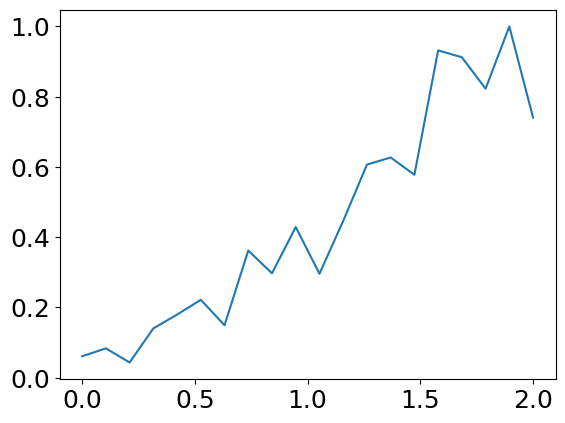

In [90]:
plt.plot(gamma_lin,np.exp(obj_out-obj_out.max()))
plt.savefig(plot_path+'gamma_test_outer.png')

In [91]:
#here are the truths from Jake's example notebook.
# I should ask emily for disk properties... 
#inner_stream_prog0 = dict(x_prog=60.0,y_prog=40.0,z_prog=40.0,f_circ=.6,v_x_hat=.6, v_y_hat=.5,pm=-1.0,
             #            log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,gamma=1.,beta=3.,
             #            t_age=7000., N_arm=4_000) #4_000


In [92]:
from nautilus import Prior
from nautilus import Sampler
#nested sampling

prior = Prior()
#specifing priors and naming paramters for nautilys t see
# everything is a top hat, lower and upper bound 
#could be flat, gaussian 
#guessing all of these should match the free params above.... 
prior.add_parameter('y_prog', dist=(-100, 100.))
prior.add_parameter('f_circ', dist=(.45, 1.3))
prior.add_parameter('v_x_hat', dist=( -1/np.sqrt(2), 1./np.sqrt(2)))
prior.add_parameter('v_y_hat', dist=( -1/np.sqrt(2), 1./np.sqrt(2)))
prior.add_parameter('log10_m_halo', dist=( 11.5,13.5))
#prior.add_parameter('log10_m_halo', dist=( 11.5,12.5))
#prior.add_parameter('r_s', dist=( 6.,24.))
prior.add_parameter('r_s', dist=( 12.,30.))
prior.add_parameter('gamma', dist=( 0.,2.))
prior.add_parameter('beta', dist=( 1.,4.))
#prior.add_parameter('beta', dist=( 2.,4.))
prior.add_parameter('t_age', dist=( 5_500.,8_500.))


# Here's where I decide what to fix, can swap around these from the ones above too...! 
params_fix_inner =  dict(x_prog=x_center_inner1, z_prog=y_center_inner1, pm=-1.,log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2)
#params_fix_outer =  dict(x_prog=x_center_outer1, z_prog=y_center_outer1, pm=1.,log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2)


#nautilys likes to have only inpu to be free parmaeters (first argument)
#all the other arguments are cfixed 
cost_naut = lambda params: vectorized_cost(params,params_fix_inner, dat_inner[:,0], dat_inner[:,1])


In [93]:
print(x_center_inner1)
print(y_center_inner1)
print(y_center_inner3)

75.84480600750936
66.08260325406758
15.769712140175216


In [94]:
#hours vs minutes below: nbatch how many streams do we generate for a single step of the sampler 
# ran 18000 streams while we had lunch
# nlive (all in nautulus documentation) making nlive lower, is afster, at the cost of accuracy 
# nautilus has recommendations: nested sampling... 
#nested smapling: puts down 2000 poiunts here, look for likelihood that is
# as you slize up. 
# nested sampling: if otyher peak: the slize will cut through both. Avoids jumoing from peak to oeak
sampler = Sampler(prior, cost_naut, n_live=1_000,vectorized=True,n_batch=500
                 )

In [95]:
sampler.run(verbose=True, )


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    


/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Finished  | 11     | 1        | 4        | 20000    | N/A    | 10215 | -10.09   


True

In [96]:
points, log_w, log_l = sampler.posterior(equal_weight=False)


In [97]:
dict_save = dict(points=points, log_w=log_w, log_l=log_l)


## Need to find true parameters for corner plot

In [112]:
# To find true params in correct units for cornerplot:
#Pos today 

pos_today_true = jnp.array([x_center_inner1, y_center_inner3, y_center_inner1])
print('pos_today [x, y (los), z]')
print(pos_today_true)
print('')
#vel today
vx_today =np.round(binned_velocities_i1[prog_inner1_index],1)
vy_today = np.round(binned_velocities_i3[prog_inner3_index],1)
vz_today = np.round(binned_velocities_i2[prog_inner2_index],1)
vel_today =  jnp.array([vx_today, vy_today, vz_today])
print('vel_today  [vx, vlos, vz]')
print(vel_today)
print('')
v_mag = (vx_today**2 + vy_today**2 + vz_today**2)**0.5
print('v_mag')
print(v_mag)
print('')
vx_hat_today = vx_today / v_mag
vy_hat_today = vy_today / v_mag
vz_hat_today = vz_today / v_mag
v_hat_today = jnp.array([vx_hat_today , vy_hat_today , vz_hat_today ])
print('v_hat')
print(v_hat_today)
print('')
#sanity check that below is same as vz_hat
#jnp.sqrt(1.0 - vx_hat**2 -vy_hat**2)*pm


pos_today [x, y (los), z]
[75.84480601 15.76971214 66.08260325]

vel_today  [vx, vlos, vz]
[134.9  66.6 -41.2]

v_mag
155.98400559031685

v_hat
[ 0.86483226  0.42696685 -0.26412964]



In [99]:
# to get circ velocity today and find fcirc, we need the potential...

#SP: for true values I need to do a bit of tweaking since I didn't run the stream myself.. 
#Should generalize below for all different streams... 

#this needs to be correct potential from BFE....!
params = {'m_disk':10**jnp.log10(5e10), 'a_disk': 3.0, 'b_disk': 0.2, 'M': 10**13.0,
                          'r_s': 22.0, 'gamma': 1.0, 'beta':3, 't_age':7000}
    #here's where the potentials are defined
    #JaxStreams: can add your own potential
pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=params['r_s'], 
                                     gamma=params['gamma'], beta=params['beta'],interp_func=interp_func,
                                              units=usys)
    
    #combine potentials while putting them in list. 
potential_list = [pot_disk,pot_halo]
pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
pm=-1


vel_circ_today = pot.local_circular_velocity(pos_today_true,0.0)*(u.kpc/u.Myr).to(u.km/u.s)
print(vel_circ_today)
f_circ_today = v_mag/vel_circ_today
print(f_circ_today)


456.599178433691
0.34162130147803016


In [100]:
#triuth params from fire run
# 
# # true_params = jnp.array([inner_stream_prog0['y_prog'], 
#                         inner_stream_prog0['f_circ'],
#                         inner_stream_prog0['v_x_hat'],
#                         inner_stream_prog0['v_y_hat'],
#                         inner_stream_prog0['log10_m_halo'],
#                         inner_stream_prog0['r_s'],
#                         inner_stream_prog0['gamma'],
#                          inner_stream_prog0['beta'],
#                          inner_stream_prog0['t_age']
#                         ])


    # v_z_hat = jnp.sqrt(1.0 - v_x_hat**2 - v_y_hat**2)*pm
    # pos_today = jnp.array([x_prog, y_prog, z_prog])
    # circular_vel = pot.local_circular_velocity(pos_today,0.0) #275.0*(u.km/u.s).to(u.kpc/u.Myr)#
    # velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*circular_vel*f_circ
    # w_today = jnp.hstack([pos_today, velocity_today])

#np.round(binned_velocities_o1[prog_outer1_index],1)
#pos_today_true = jnp.array([x_center_outer1, y_center_outer3, y_center_outer1])
#vx_true = np.round(binned_velocities_o1[prog_outer1_index],1)/pot.local_circular_velocity(pos_today_true,0.0)/1.2


inner_stream_prog0 = dict(x_prog=x_center_inner1,y_prog=y_center_inner3,z_prog=y_center_inner1,f_circ=f_circ_today,v_x_hat=vx_hat_today, v_y_hat=vy_hat_today,pm=-1.0,
                        log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,gamma=1.,beta=3,
                         t_age=7000., N_arm=4_000) #4_000



true_params = jnp.array([inner_stream_prog0['y_prog'], 
                        inner_stream_prog0['f_circ'],
                        inner_stream_prog0['v_x_hat'],
                        inner_stream_prog0['v_y_hat'],
                        inner_stream_prog0['log10_m_halo'],
                        inner_stream_prog0['r_s'],
                        inner_stream_prog0['gamma'],
                         inner_stream_prog0['beta'],
                         inner_stream_prog0['t_age']
                        ])


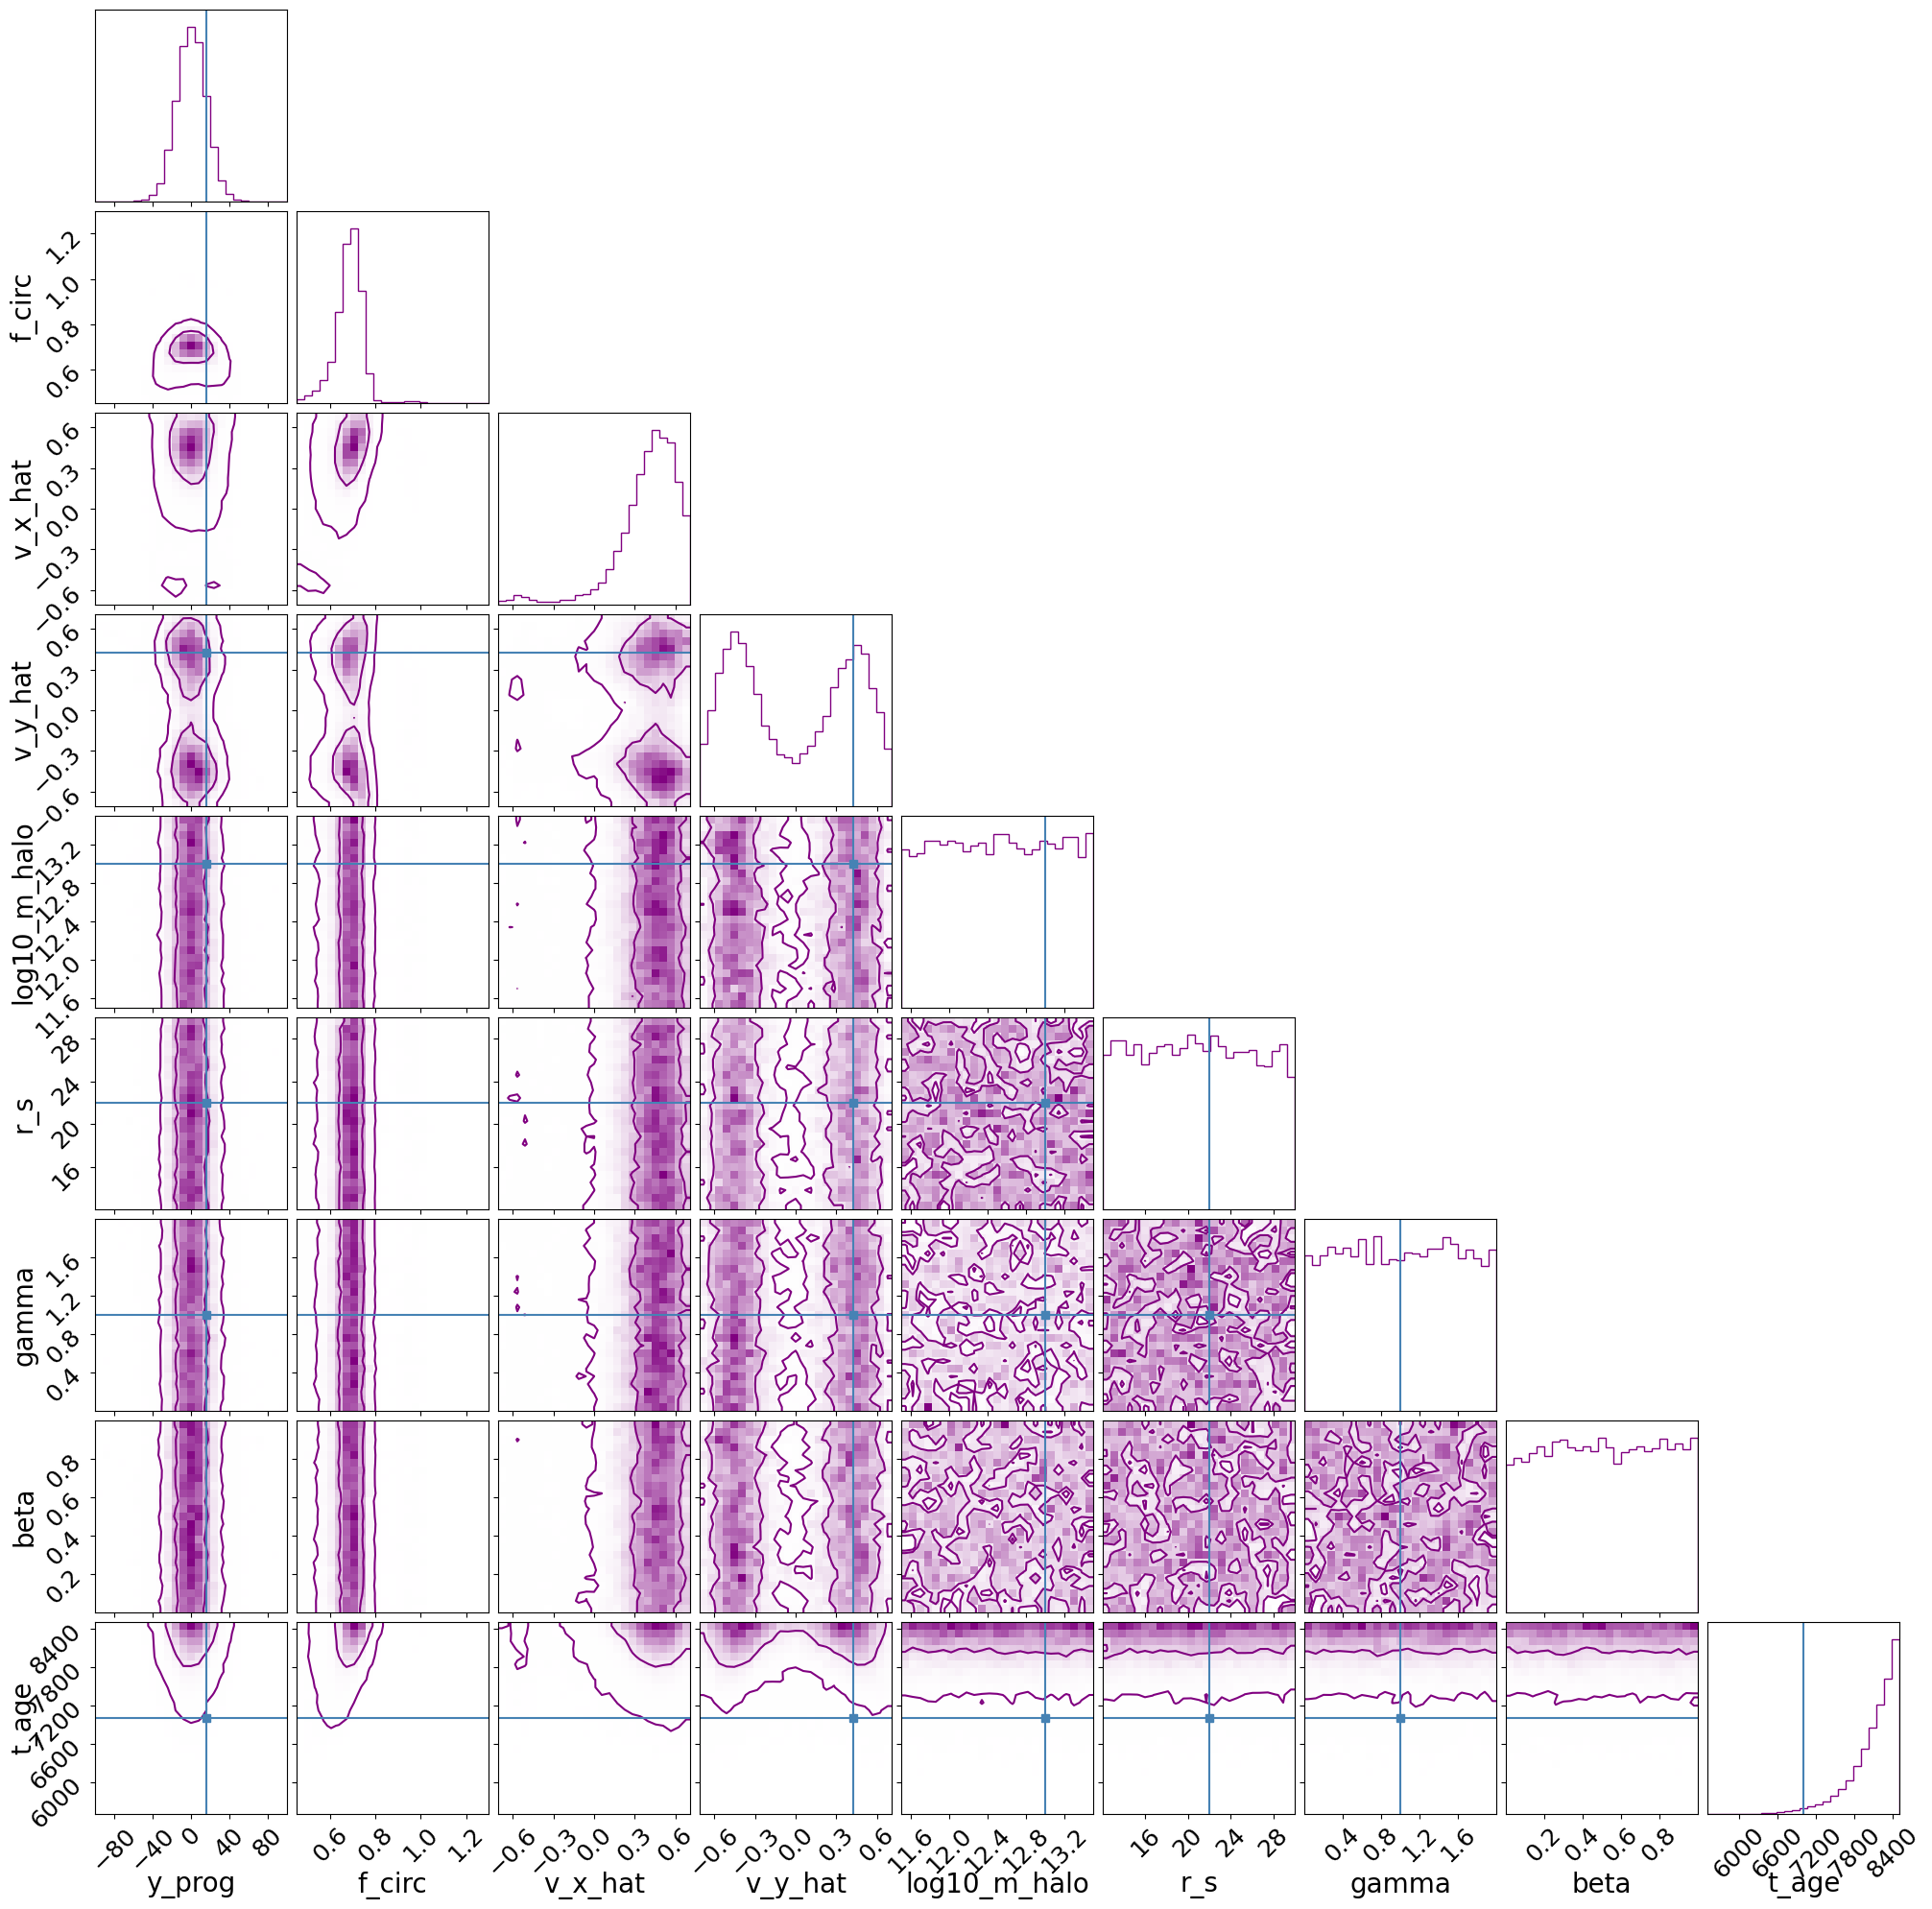

In [101]:
import corner
corner.corner(
    points, weights=np.exp(log_l-log_l.max()), bins=25, labels=prior.keys, color='purple',
    plot_datapoints=False, truths=true_params,levels=(0.67,0.95),
smooth=.5);

# #omitting true parameters below.. 
# import corner
# corner.corner(
#     points, weights=np.exp(log_l-log_l.max()), bins=25, labels=prior.keys, color='purple',
#     plot_datapoints=False, levels=(0.67,0.95),
# smooth=.5);

In [102]:
# # now write the new wcs based on changes from sim
# wcs_input_dict = hdulist[0].header
# wcs_helix_dict = WCS(wcs_input_dict)
# header = hdulist[0].header
# wcs_helix = WCS(header)

In [103]:
#wcs_helix 

## Plot sim data as Cen A data

In [104]:
##make sure control points are orderd in RA for fitting
#control_points
#idx_sort = np.argsort(control_points[0,:])
#centroids = control_points[idx_sort]
#control_points 
#idx_sort

In [105]:
#Now want to include correct spacing
 

## Set up potential

In [106]:
#dec_bins

In [107]:
#c_centroids# =  coord.SkyCoord(control_points[idx_sort])
#idx_sort

# Input

## Check best fit orbit in fiducial potential
Check all three velocity components but assume dwarf is at same los-distance as host


In [108]:
#vx[12]

## Visualize best fit orbit 


# Make zoomed version of vel space

In [109]:
# save this file too so I don't need to rerun all the time 

In [110]:
np.where(lnL_fiducial_zoom == np.min(lnL_fiducial_zoom))

NameError: name 'lnL_fiducial_zoom' is not defined

## Now change the distance to FireDw
Until now we've assumed that the line of sight distance to the FIREDw is the same as the host galaxy.

How do the best fit orbits differ if we move the dwarf in front of or behind? How do we want to test this...? FIrst infront, then behind...? Or run a whole grid

## 100 kpc farther than host (behind host)

## 100 kpc closer than host

In [ ]:
#np.where(lnL_fiducial_closer[0,:,:] == np.min(lnL_fiducial_closer[0,:,:]))

# Notes so far

vphi1, vphi2 keep being in the same range with all vrads and los distances.

If we move the dwarf behind vs in front of the host galaxy, the very best solutions kind of flips from pairs of negative vrad + closer los distance to positive vrad + further los distance 

But there seem to be similar solitions across pretty much most vrads, and it's hard to get a best fit orbit...

## now using Emily's numbers

In [ ]:
# Relative radial velocity of progenitor: 38 km/s
# Relative distance: 90 kpc

# bound stellar mass of the remnant at z= 0 is 1.2e8 M_sun...
# So use this as lower r_J limit?

#fix these and loop over other velocities

## Now zooming 

In [ ]:
lnL_input

The above plot shows using fixed stream prog distance (90 kpc farther) and radial velocity (+38 km/s with respect to host) and zooming on two other velocity components of grid to find best fit orbit. This is kind of where we left off in P22b, so maybe it's okay to start from here with FIRE-2? 

# Paper figures

## Sec 3.1: Reproducing P22b fig 7

In [ ]:
#Should get initial halo mass from abundance matching from stellar mass and maybe use stellar mass
# for hernquist profile

In [ ]:
# takes a while so I've commented in out and stored the outputs, loaded them in below instead

# #also loop over potentials, zoomed over the range of parameter space of orbits that's useful

# lnL_allhalos = np.zeros([len(pot_cenA_range),len(vj_fid), len(vk_fid)])
# lnL_rt_allhalos = np.zeros([len(pot_cenA_range),len(vj_fid), len(vk_fid)])

# j=0
# for pot in pot_cenA_range:
#     #print(pot['halo'])
#     print("pot " + str(j+1))
#     k = 0
#     #loop over vz and vy so I can store different lnL?
#     for vj in vj_fid:
#         i = 0
#        # print(str(vj)+' km/s')
#         for vk in vk_fid:
#             v = np.array([vx[0],vj,vk])*u.km/u.s
#             lnL_j,lnL_rt_j = call_lnL(lnL_input, v, pot = pot, plot=False, verbose=False)
#             #print(lnL_j)
#             lnL_allhalos[j,k,i] = lnL_j
#             lnL_rt_allhalos[j,k,i] = lnL_rt_j
#             i = i+1    
#         k = k +1
#     j = j +1





In [ ]:
# Fig 7 of P22b

#pmesh of all potentials

#Maybe move this fig below, so we can plot velocity as green marker 

#Use meshgrid instead
#colormap1 = matplotlib.cm.RdPu_r#viridis_r#Blues_r#tab20c
#colormap = matplotlib.cm.RdPu_r#
#plt.figure(figsize=(7,6.8))

colormap = matplotlib.cm.RdPu_r#viridis_r#Blues_r#tab20c
#plt.figure(figsize=(7,6))
plt.figure(figsize=(9, 7.5))
#should be   8, 7.5 instead but need to check colorbar .... 

X, Y = np.meshgrid(vj_fid ,vk_fid)

k = 0
for k in range(len(pot_cenA_range)):
   
    plt.pcolormesh(X, Y, lnL_rt_load[k].T, vmin=0, vmax=50, shading='auto',cmap=colormap)
    plt.colorbar(label=r'$-$ln$L$')#, fontsize=20)
    #plt.colorbar(label=r'$-$ln$L$')#, fontsize=24)
    
    #also plot marker where velocity is. np.where()
    plt.scatter(vel_k_rt[k][0], vel_k_rt[k][1], marker='*', color='lightgray', s=200, label=r'$-$ln$L$ = ' + str(np.round(np.min(lnL_rt_load[k]),2) ))
    
    #might not even want colorbar here either
    
    plt.text(160,23, 'Halo ' + str(k+1) + ': M$_{200}$ = ' +str(np.round(m_halo_range[k].value/1e12,2)),\
             fontsize=26)
    plt.xlim([100,800])
   # plt.xticks([])
    plt.ylim([20,195])
    plt.xlabel('$v_{\phi_1}$ [km/s]', fontsize=28)
    plt.ylabel('$v_{\phi_2}$ [km/s]', fontsize=28)
    plt.tight_layout()
    plt.legend(loc='upper left', fontsize=26)
    number_str = str(k+1)
    zero_filled_number = number_str.zfill(3)
    plt.savefig(plot_path + str(zero_filled_number)+'rt_mdw1e8_mhalo_' + str(np.round(pot_cenA_range[k]['halo'].parameters['m'].value/10**12,2))+'e12_pmesh.png')
    plt.clf()

    k = k+1

                ##+str(np.round(m_halo_range[k].value/10**12,2))+'e12_pmesh.png')

In [ ]:
#Do this at different projected distances of m12m
# could use erros from Denja's paper

## Sec. 3.2: Building in distances + vrad along the stream to fit

## Sec. 3.3: Now setting up non-spherical NWFs
Reorient the halos and see what I recover for the NWF shape...

## Sec. 3.4: how do multiple streams help
Remove observables systematically and see if we can still constrain shape + enclosed mass.